## Business Problem

Nowadays, more people are using social media to express problems and compliments to companies. It is an easy and cheap way for companies to get feedback from consumers. However, the larger a company is, the more difficult it gets to analyze what people are talking about and how a company should improve. Feedback is valuable information that is difficult to get and can be expensive to collect. Thus, creating a way to automate sentiment detecting and critical points that people are talking about can help companies improve their products.

<strong>Business Question</strong>

Can a model predict companies' sentiment perception on tweets?

Does sentiment analysis perform better on raw tweets or cleaned tweets?

<strong>Data</strong>

It was used around 18,000 web scrapped tweets mentioning Google and Apple using Twint. It was collected information such as the tweet text, language, location, date, and username. It was also a dataset from CrowdFlower provided by Flatiron School with 9,093 observations with the tweet text, a keyword, and the emotion. The emotion was divided in Nagative, Positive, and No emotion toward brand or product.

## Import Packages

In [103]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from sklearn import metrics
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import logging
from textblob import TextBlob 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, precision_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Pandas Settings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('eda/judge-1377884607_tweet_product_company.csv',encoding = 'unicode_escape')

## Initial EDA

In this stage, we will explore our data sets and make plans for the next steps based on what we learn. The main objective is to understand out features and if we have null values to deal with.

In [3]:
# Check DataFrame 
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [4]:
# Checking in one of the columns
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
# Checking values in the target columns
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
# Checking null values
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
# Checking the shape of the dataframe
df.shape

(9093, 3)

#### Takeaways:

- The column names are a little confusing. We will rename it.
- There is a class imbalance for our target. We will test models with the class imbalance and fixing class imbalance
- There is a lot of class null values that we will have to work on. Most of the null values are in `company` column. We can do some feature engineering using the tweets
- There is very little information to create visualizations.

### Renaming Columns

Let's rename a few columns to make the dataframe more readable.

In [8]:
# Renaming columns
df.columns=['tweet','company','emotion']
df.head()

tweet             company  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

In [9]:
df = df.drop([6]).reset_index(drop=True)

In [10]:
# Checking the emotion columns values count
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [11]:
# Recategorizing targeting variable
df['emotion'] = df['emotion'].apply(lambda x: "No emotion toward brand or product" if x == "I can't tell" else x)

In [12]:
# Checking if the lambda function worked
df['emotion'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [13]:
# Dropping null tweets
df.tweet.dropna(inplace=True)

In [14]:
# Deleting null tweets
df.isna().sum()

tweet         0
company    5801
emotion       0
dtype: int64

#### Takeaways:
- We renamed the columns to make the data more readable
- We recategorized the target variable `emotion` reducing its size. To do so, we renamed the 'I can't tell' value to 'No emotion toward brand or product'
- Since we will use tweets to predict our variable, we deleted null tweets

## Data Cleaning and Feature Engineering

In  this chapter, we will start our data set. Since it's NLP, we will remove all the data that we don't need. We will keep columns of each step of the data cleaning and compared the results.

In [15]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)

    return text

round1 = lambda x: clean_text_round1(x)

In [16]:
# Let's look how the cleaned tweets look like
df['clean_tweets'] = pd.DataFrame(df.tweet.apply(round1))
df.head()

tweet             company  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion                                       clean_tweets  
0  Negative emotion      i have a   iphone  after   hrs tweeting at...  
1  Positive emotion   jessedee know about  fludapp   awesome ipad i...  
2  Positive emotion   swonderlin can not wait for  ipad   also  the...  
3  Negative emotion   sxsw i hope this year s festival isn t as cra...  
4  Positive emotion   sxtxstate great stuff on fri  sxsw  marissa m...

### Identifying Product Names in Tweets

In [17]:
# We will clean the punctuation in case we missed something
punctuation=[",",".","#","!","@","$","?","$","%","&","-","_",":","=", "/",";",'(',")", "{","}","|"]
apple=['iPhone',"iphones",'i phones',"iPad&quot;","iphone ",'i Pad','i Pad',"Apple.","iPad?","#iPad","#iPhone",'iPad','Mac',"iphone,",'iPod','ipod','ipad','mac','Apple','apple','Apple\'s','apple\'s',"#Apple",'#apple','I-Pad']
google=['Google','google','android','Android','Google.','android,',"#android",'Google\'s','google\'s','googles' ,'#google','#Google']

In [18]:
# Function interated through each tweet and adds values to the column company based on them
for index in df.index:
    tweet="".join(i if i not in punctuation else " " for i in df.tweet[index])
    condition=0
    df.tweet[index]=tweet

    
    if bool(set(tweet.split())&set(apple))==True:
        df.company[index]=(list(set(tweet.split())&set(apple))[0].title().strip('\'s')).strip('\'S')
        condition=1
    else:
        condition=0
        
    if (bool(set(tweet.split())&set(google))==True) and condition==0:
        df.company[index]=(list(set(tweet.split())&set(google))[0].title().strip('\'s')).strip('\'S')
        
    elif (bool(set(tweet.split())&set(google))==True) and condition==1:
        df.company[index]+= " & "+(list(set(tweet.split())&set(google))[0].title().strip('\'s')).strip('\'S')

In [19]:
df.head()

tweet company  \
0    wesley83 I have a 3G iPhone  After 3 hrs twe...  Iphone   
1   jessedee Know about  fludapp   Awesome iPad i...    Ipad   
2   swonderlin Can not wait for  iPad 2 also  The...    Ipad   
3   sxsw I hope this year's festival isn't as cra...  Iphone   
4   sxtxstate great stuff on Fri  SXSW  Marissa M...  Google   

            emotion                                       clean_tweets  
0  Negative emotion      i have a   iphone  after   hrs tweeting at...  
1  Positive emotion   jessedee know about  fludapp   awesome ipad i...  
2  Positive emotion   swonderlin can not wait for  ipad   also  the...  
3  Negative emotion   sxsw i hope this year s festival isn t as cra...  
4  Positive emotion   sxtxstate great stuff on fri  sxsw  marissa m...

#### Takeaways:

- We removed all the numbers and punctuations and numbers and added to a new column called `clean_tweets`
- We created lists with all the variations of Apple and Google products
- We used the product variations lists to identify what was the subject mentioned in the tweets text

### Create Company Column

As we can see, there is a `company` column. However, instead the name of the company, it has the name of the company mixed with the name of the products. We will then create a column with the company name based on their products.

In [20]:
# Checking unique values for the company column
df.company.unique()

array(['Iphone', 'Ipad', 'Google', 'Android', 'Apple', 'Iphone & Android',
       'Apple & Google', nan, 'iPad', 'Ipad & Android',
       'iPad or iPhone App', 'Mac', 'iPhone', 'Ipad & Google', 'Ipod',
       'Iphone & Google', 'Other Apple product or service',
       'Other Google product or service', 'Apple & Android',
       'Ipod & Android', 'Mac & Android'], dtype=object)

In [21]:
# Lists with the company's values
apple_products = ['Iphone', 'Ipad', 'Apple','iPad','iPad or iPhone App', 'Mac', 'iPhone', 
                'Other Apple product or service', 'Ipod']
google_products = ['Google', 'Android', 'Ipod','Other Google product or service']
other_products = ['Iphone & Android', 'Apple & Google', 'Ipad & Android','Ipad & Google',
       'Iphone & Google','Apple & Android', 'Ipod & Android', 'Mac & Android']

In [22]:
# Renaming columns
df.columns=['tweet','product','emotion','clean_tweets']
df.head()

tweet product  \
0    wesley83 I have a 3G iPhone  After 3 hrs twe...  Iphone   
1   jessedee Know about  fludapp   Awesome iPad i...    Ipad   
2   swonderlin Can not wait for  iPad 2 also  The...    Ipad   
3   sxsw I hope this year's festival isn't as cra...  Iphone   
4   sxtxstate great stuff on Fri  SXSW  Marissa M...  Google   

            emotion                                       clean_tweets  
0  Negative emotion      i have a   iphone  after   hrs tweeting at...  
1  Positive emotion   jessedee know about  fludapp   awesome ipad i...  
2  Positive emotion   swonderlin can not wait for  ipad   also  the...  
3  Negative emotion   sxsw i hope this year s festival isn t as cra...  
4  Positive emotion   sxtxstate great stuff on fri  sxsw  marissa m...

In [23]:
# Creating a company name based on thj\e products value
df['company'] = df['product'].apply(lambda x: 'Apple' if x in apple_products else 'Google' if x in google_products else 'Other')

In [24]:
# Fixes some brands names
df['product'] = df['product'].apply(lambda x: "iPad" if x == "Ipad" else x)
df['product'] = df['product'].apply(lambda x: "iPhone" if x == "Iphone" else x)
df['product'] = df['product'].apply(lambda x: "iPod" if x == "Ipod" else x)

In [25]:
# Checking if the new column works
df.company.value_counts()

Apple     5151
Google    2794
Other     1147
Name: company, dtype: int64

In [26]:
# Checking unique values for the product column
df['product'].unique()

array(['iPhone', 'iPad', 'Google', 'Android', 'Apple', 'Iphone & Android',
       'Apple & Google', nan, 'Ipad & Android', 'iPad or iPhone App',
       'Mac', 'Ipad & Google', 'iPod', 'Iphone & Google',
       'Other Apple product or service',
       'Other Google product or service', 'Apple & Android',
       'Ipod & Android', 'Mac & Android'], dtype=object)

#### Takeaways:
- Renamed the columns
- We created a new company column with the values Apple, Google, and Others based on the products mentioned in the tweets
    - We created lists of products for Apple, Google, and Other Products
    - We used the products name to create the new company column
- We renamed values to match to the original products names.

## Data Cleaning Round 2

We will run a second round of data cleaning to create a column with only English words.

In [27]:
# Create a new column only with English words
words = set(nltk.corpus.words.words())
df['only_english_words'] = ''

for index in df.index:
    sent = df.clean_tweets[index]
    df['only_english_words'][index] = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())

In [28]:
# Reorganing the column
df = df[['tweet', 'clean_tweets', 'only_english_words', 'product', 'company','emotion']]
df.head()

tweet  \
0    wesley83 I have a 3G iPhone  After 3 hrs twe...   
1   jessedee Know about  fludapp   Awesome iPad i...   
2   swonderlin Can not wait for  iPad 2 also  The...   
3   sxsw I hope this year's festival isn't as cra...   
4   sxtxstate great stuff on Fri  SXSW  Marissa M...   

                                        clean_tweets  \
0      i have a   iphone  after   hrs tweeting at...   
1   jessedee know about  fludapp   awesome ipad i...   
2   swonderlin can not wait for  ipad   also  the...   
3   sxsw i hope this year s festival isn t as cra...   
4   sxtxstate great stuff on fri  sxsw  marissa m...   

                                  only_english_words product company  \
0  i have a after at rise it was dead i need to u...  iPhone   Apple   
1  know about awesome that you likely appreciate ...    iPad   Apple   
2  can not wait for also they should sale them do...    iPad   Apple   
3    i hope this year s festival t as as this year s  iPhone   Apple   
4                              great stuff on o tech  Google  Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

#### Takeaways:
- We created a new column removing all non-English words, including products names that aren't in the English dictionary and reorganized the columns

## Top Words

We will create some word clouds to see if our data set makes sense and if our data cleaning words.

In [29]:
# Delete commom twitter words
from sklearn.feature_extraction import text 
add_stop_words = ['mention', 'link', 'rt', 'quot', 'amp', 'sxsw']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

### Functions for Top Words

In [51]:
# Function to create dictionaries with column names
def top_words(column_name):
    dictionary={}
    brands=list(df['company'].unique())
    for brand in brands:
        tweet=''
        for index in df[df['company']==brand].index:
            tweet+=df[column_name][index]+' '
        dictionary[brand]=tweet
    return dictionary

In [52]:
# We are going to change this to key: brand, value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ''.join(list_of_text)
    return combined_text

In [53]:
# We can either keep it in dictionary format or put it into a pandas dataframe
def dict_to_dataframe(data_combined, column_name):
    data_df = pd.DataFrame.from_dict(data_combined).transpose()
    data_df.columns = [column_name]
    data_df = data_df.sort_index()
    return data_df

In [54]:
# Find the top 30 words said by each comedian
def top_30_words(tk_dataframe):
    top_dict = {}
    for word in tk_dataframe.columns:
        top = tk_dataframe[word].sort_values(ascending=False).head(30)
        top_dict[word] = list(zip(top.index, top.values))
    return top_dict

In [55]:
# Applying top_words function
dict_tweet = top_words('tweet')
dict_clean = top_words('clean_tweets')
dict_english = top_words('only_english_words')

In [56]:
# Applying combine_text function
data_combined_tweet = {key: [combine_text(value)] for (key, value) in dict_tweet.items()}
data_combined_clean = {key: [combine_text(value)] for (key, value) in dict_clean.items()}
data_combined_english = {key: [combine_text(value)] for (key, value) in dict_english.items()}

In [57]:
# Converting combined dictionary to dataframe
data_tweet = dict_to_dataframe(data_combined_tweet,'tweet')
data_clean = dict_to_dataframe(data_combined_clean,'clean_tweets')
data_english = dict_to_dataframe(data_combined_english,'only_english_words')

#### Takeaways:
- We removed all the common Twitter words such as mention, link, rt, etc.
- We created multiple functions to avoid code repetition
- We vectorized the columns to create a Word Cloud

### Dictionaries with Top Words

Let's create a dictionary with the top words for each of the data cleaning step.

In [58]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe without data cleaning
data_tweet_cv = cv.fit_transform(data_tweet.tweet)
tk_tweet = pd.DataFrame(data_tweet_cv.toarray(), columns = cv.get_feature_names())
tk_tweet.index = data_tweet.index

In [59]:
# Fit and transform dataframe with data cleaning, but with non-English words
data_clean_cv = cv.fit_transform(data_clean.clean_tweets)
tk_clean = pd.DataFrame(data_clean_cv.toarray(), columns = cv.get_feature_names())
tk_clean.index = data_clean.index

In [60]:
# Fit and transform dataframe with all the data cleaning steps
data_english_cv = cv.fit_transform(data_english.only_english_words)
tk_english = pd.DataFrame(data_english_cv.toarray(), columns = cv.get_feature_names())
tk_english.index = data_english.index

In [61]:
# Transpose dataframes
tk_tweet = tk_tweet.transpose()
tk_clean = tk_clean.transpose()
tk_english = tk_english.transpose()

In [62]:
# Applying top_30_words function
top_words_tweet = top_30_words(tk_tweet)
top_words_clean = top_30_words(tk_clean)
top_words_only_english = top_30_words(tk_english)

In [63]:
# Print the top 15 words
def top_15_words(top_words_dict):
    for brand, top_words in top_words_dict.items():
        print(brand)
        print(', '.join([word for word, count in top_words[0:14]])+'\n')
    print('---')

In [65]:
'''Prints dictionary with all the top words. Uncomment to see'''

print('Top Words Before Data Cleaning')
top_15_words(top_words_tweet)
print('\n')
print('Top Words After Data Cleaning')
top_15_words(top_words_clean)
print('\n')
print('Top Words After Removing Non-English Words')
top_15_words(top_words_only_english)

Top Words Before Data Cleaning
Apple
ipad, apple, store, iphone, austin, pop, app, new, ipad2, just, line, temporary, opening, downtown

Google
google, circles, social, new, network, launch, android, today, called, major, party, possibly, mobile, maps

Other
iphone, android, free, app, austin, new, sxswi, music, 11, ipad, itunes, today, mobile, download

---


Top Words After Data Cleaning
Apple
ipad, apple, store, iphone, austin, pop, app, new, just, line, temporary, opening, downtown, popup

Google
google, circles, social, new, network, launch, android, today, called, major, party, possibly, mobile, maps

Other
iphone, android, free, app, austin, new, sxswi, music, ipad, itunes, today, mobile, download, check

---


Top Words After Removing Non-English Words
Apple
apple, store, pop, new, just, line, temporary, opening, downtown, launch, open, like, free, time

Google
social, new, network, launch, android, today, major, party, possibly, mobile, just, search, bing, location

Other
andr

#### Takeways:

- The data cleaning words. We can see the top words changing in each of the data cleaning step
- After removing non-English words, all apple brands disappeared, but we can see some other brands such as android and blackberry. This might affect the model prediction.
- SXSWI is related to a conference that happened in 2011. Most of the tweets are taking about the conference.

## Word Cloud

In [73]:
# Let's make some word clouds!
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

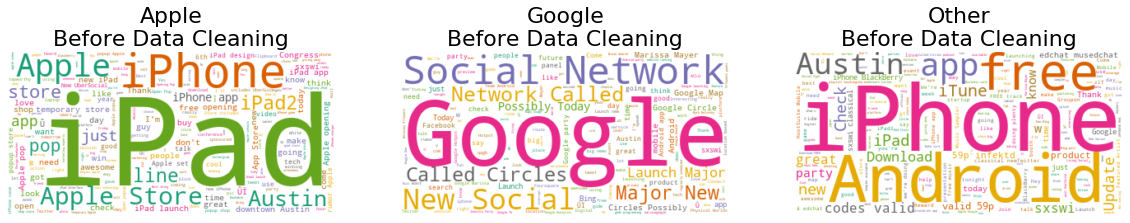

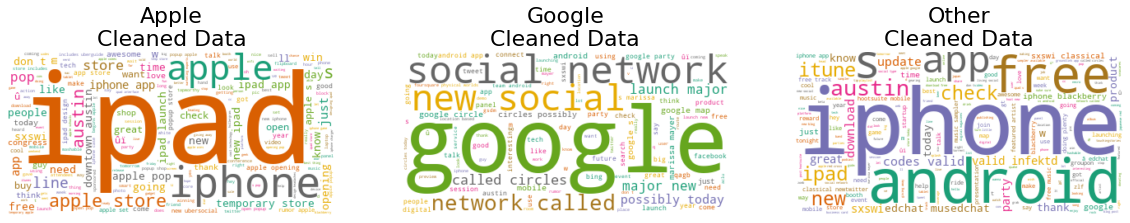

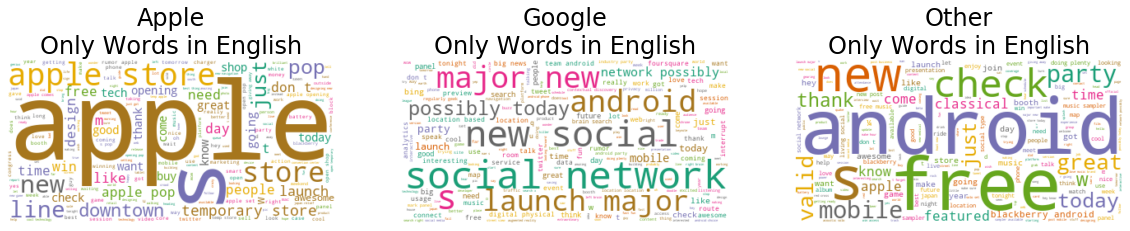

In [83]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [20, 20]

brands = ['Apple', 'Google', 'Other']

# Create subplots for dataframe before data cleaning

for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_tweet.tweet[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index]+'\nBefore Data Cleaning' ,fontsize=22)
    plt.savefig('mytable.png')
plt.show()

# Create subplots after data cleaning
for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_clean.clean_tweets[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index]+'\nCleaned Data', fontsize=22) 
    plt.savefig('mytable.png')
plt.show()

# Create subplots after removing non-English words
for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_english.only_english_words[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index]+'\nOnly Words in English', fontsize=24)
    plt.savefig('mytable.png')
plt.show()  


#### Findings:

- The word cloud shows us that the data cleaning has worked. We don't see many stop words and the top words seems relevant to the content.

### Testing Polarity

In this step, we will test the polarity with raw and cleaned data.

In [69]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [70]:
# Create new columns to compare polarity and subjetivity
df['subjectivity_tweet'] = df['tweet'].apply(getSubjectivity)
df['subjectivity_clean'] = df['clean_tweets'].apply(getSubjectivity)
df['subjectivity_english'] = df['only_english_words'].apply(getSubjectivity)
df['polarity_tweet'] = df['tweet'].apply(getPolarity)
df['polarity_clean'] = df['clean_tweets'].apply(getPolarity)
df['polarity_english'] = df['only_english_words'].apply(getPolarity)

In [84]:
# Checking head of the dataframe
df.head()

tweet  \
0    wesley83 I have a 3G iPhone  After 3 hrs twe...   
1   jessedee Know about  fludapp   Awesome iPad i...   
2   swonderlin Can not wait for  iPad 2 also  The...   
3   sxsw I hope this year's festival isn't as cra...   
4   sxtxstate great stuff on Fri  SXSW  Marissa M...   

                                        clean_tweets  \
0      i have a   iphone  after   hrs tweeting at...   
1   jessedee know about  fludapp   awesome ipad i...   
2   swonderlin can not wait for  ipad   also  the...   
3   sxsw i hope this year s festival isn t as cra...   
4   sxtxstate great stuff on fri  sxsw  marissa m...   

                                  only_english_words product company  \
0  i have a after at rise it was dead i need to u...  iPhone   Apple   
1  know about awesome that you likely appreciate ...    iPad   Apple   
2  can not wait for also they should sale them do...    iPad   Apple   
3    i hope this year s festival t as as this year s  iPhone   Apple   
4                              great stuff on o tech  Google  Google   

            emotion  subjectivity_tweet  subjectivity_clean  \
0  Negative emotion            0.400000            0.400000   
1  Positive emotion            0.933333            0.933333   
2  Positive emotion            0.288889            0.288889   
3  Negative emotion            0.000000            0.000000   
4  Positive emotion            0.750000            0.750000   

   subjectivity_english  polarity_tweet  polarity_clean  polarity_english  
0              0.400000       -0.200000       -0.200000         -0.200000  
1              0.933333        0.466667        0.466667          0.466667  
2              0.288889       -0.155556       -0.155556         -0.155556  
3              0.000000        0.000000        0.000000          0.000000  
4              0.750000        0.800000        0.800000          0.800000

In [132]:
# Creates a new column comparing the text blob results to the data set original analysis
df['emotion_textblob'] = df['polarity_english'].apply(lambda x: 'Negative Emotion' if x < 0 else 'No emotion toward brand or product' if x == 0 else 'Positive emotion')

In [85]:
# Drop the subjetivity and polarity columns
df.drop(columns=['subjectivity_tweet', 'subjectivity_clean',
       'subjectivity_english', 'polarity_tweet', 'polarity_clean',
       'polarity_english'], inplace=True)

#### Findings:
- None of the data cleaning seems to affect the polarity of the tweets. All the numbers are the same in every step


## Vanilla Model

In this section, we fit models without lemmatization or stemming

In [136]:
# Evaluation function

def evaluation(y_true, y_pred):
       
# Print Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred, average="micro")))

In [143]:
# Convertes the emotion column into numbers for the model 
df['pred_target'] = df['emotion'].apply(lambda x: 0 if x=='Negative emotion' else (1 if  x=="Positive emotion" else 2))

In [147]:
# Vectorizing new feature
cv = CountVectorizer()
data_cv = cv.fit_transform(df.clean_tweets)
df_token_1 = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
df_token_1.index = df.index
df_token_1.head()

aapl  aaron  aarpbulletin  ab  abacus  abandoned  abba  aber  abilities  \
0     0      0             0   0       0          0     0     0          0   
1     0      0             0   0       0          0     0     0          0   
2     0      0             0   0       0          0     0     0          0   
3     0      0             0   0       0          0     0     0          0   
4     0      0             0   0       0          0     0     0          0   

   ability  able  abnormal  abound  about  above  abroad  absolute  \
0        0     0         0       0      0      0       0         0   
1        0     0         0       0      1      0       0         0   
2        0     0         0       0      0      0       0         0   
3        0     0         0       0      0      0       0         0   
4        0     0         0       0      0      0       0         0   

   absolutely  absolutley  abt  abuzz  academy  acc  accelerater  \
0           0           0    0      0        0    0            0   
1           0           0    0      0        0    0            0   
2           0           0    0      0        0    0            0   
3           0           0    0      0        0    0            0   
4           0           0    0      0        0    0            0   

   acceleration  accelerator  accept  acceptable  access  accessibility  \
0             0            0       0           0       0              0   
1             0            0       0           0       0              0   
2             0            0       0           0       0              0   
3             0            0       0           0       0              0   
4             0            0       0           0       0              0   

   accessible  accessories  accessory  accesssxsw  accidentally  accommodate  \
0           0            0          0           0             0            0   
1           0            0          0           0             0            0   
2           0            0          0           0             0            0   
3           0            0          0           0             0            0   
4           0            0          0           0             0            0   

   accompanied  accomplish  according  accordion  account  accounts  accuracy  \
0            0           0          0          0        0         0         0   
1            0           0          0          0        0         0         0   
2            0           0          0          0        0         0         0   
3            0           0          0          0        0         0         0   
4            0           0          0          0        0         0         0   

   acerbic  achieve  achievement  acknowledge  ackward  aclu  aclus  acoustic  \
0        0        0            0            0        0     0      0         0   
1        0        0            0            0        0     0      0         0   
2        0        0            0            0        0     0      0         0   
3        0        0            0            0        0     0      0         0   
4        0        0            0            0        0     0      0         0   

   acquired  acquisition  across  acrosse  act  acting  action  actionable  \
0         0            0       0        0    0       0       0           0   
1         0            0       0        0    0       0       0           0   
2         0            0       0        0    0       0       0           0   
3         0            0       0        0    0       0       0           0   
4         0            0       0        0    0       0       0           0   

   actions  activate  activations  activity  actors  acts  actsofsharing  \
0        0         0            0         0       0     0              0   
1        0         0            0         0       0     0              0   
2        0         0            0         0       0     0              0   
3        0         0     

In [171]:
X = df_token_1
y = df.pred_target

#### Findings:

- Since removing all non-English words removed some important information such as the name of the brands, we decided to move forward and predict with the `clean_tweets` variable 

### Train Test Split

In [172]:
# Running Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

### Upsampling

Since we have class imbalance, we will upsample the target variable.

In [191]:
# concatenate our training data back together
train_up  = pd.concat([X_train, y_train], axis=1)

In [192]:
# Checking the class imbalance
train_up.pred_target.value_counts()

2    4159
1    2218
0     442
Name: pred_target, dtype: int64

In [201]:
# Separate minority and majority classes
no_emotion = train_up[train_up.pred_target==2]
positive_emotion = train_up[train_up.pred_target==1]
negative_emotion = train_up[train_up.pred_target==0]

In [202]:
negative_emotion_upsampled = resample(negative_emotion,
                          replace=True, # sample with replacement
                          n_samples=len(no_emotion), # match number in majority class
                          random_state=23) # reproducible results

In [203]:
positive_emotion_upsampled = resample(positive_emotion,
                          replace=True, # sample with replacement
                          n_samples=len(no_emotion), # match number in majority class
                          random_state=23) # reproducible results

In [212]:
# combine majority and upsampled minority
upsampled = pd.concat([no_emotion, negative_emotion_upsampled, positive_emotion_upsampled])

# check new class counts
upsampled.pred_target.value_counts()

2    4159
1    4159
0    4159
Name: pred_target, dtype: int64

In [214]:
upsampled_token_1.head()

aapl  aaron  aarpbulletin  ab  abacus  abandoned  abba  aber  abilities  \
5      0      0             0   0       0          0     0     0          0   
15     0      0             0   0       0          0     0     0          0   
31     0      0             0   0       0          0     0     0          0   
32     0      0             0   0       0          0     0     0          0   
33     0      0             0   0       0          0     0     0          0   

    ability  able  abnormal  abound  about  above  abroad  absolutely  \
5         0     0         0       0      0      0       0           0   
15        0     0         0       0      0      0       0           0   
31        0     0         0       0      0      0       0           0   
32        0     0         0       0      0      0       0           0   
33        0     0         0       0      0      0       0           0   

    absolutley  abt  abuzz  academy  acc  accelerater  acceleration  \
5            0    0      0        0    0            0             0   
15           0    0      0        0    0            0             0   
31           0    0      0        0    0            0             0   
32           0    0      0        0    0            0             0   
33           0    0      0        0    0            0             0   

    accelerator  accept  acceptable  access  accessibility  accessible  \
5             0       0           0       0              0           0   
15            0       0           0       0              0           0   
31            0       0           0       0              0           0   
32            0       0           0       0              0           0   
33            0       0           0       0              0           0   

    accessories  accessory  accesssxsw  accidentally  accommodate  \
5             0          0           0             0            0   
15            0          0           0             0            0   
31            0          0           0             0            0   
32            0          0           0             0            0   
33            0          0           0             0            0   

    accompanied  accomplish  according  accordion  account  accounts  \
5             0           0          0          0        0         0   
15            0           0          0          0        0         0   
31            0           0          0          0        0         0   
32            0           0          0          0        0         0   
33            0           0          0          0        0         0   

    accuracy  acerbic  achieve  achievement  acknowledge  ackward  aclu  \
5          0        0        0            0            0        0     0   
15         0        0        0            0            0        0     0   
31         0        0        0            0            0        0     0   
32         0        0        0            0            0        0     0   
33         0        0        0            0            0        0     0   

    aclus  acoustic  acquired  acquisition  across  acrosse  act  acting  \
5       0         0         0            0       0        0    0       0   
15      0         0         0            0       0        0    0       0   
31      0         0         0            0       0        0    0       0   
32      0         0         0            0       0        0    0       0   
33      0         0         0            0       0        0    0       0   

    action  actionable  actions  activate  activations  activity  actors  \
5        0           0        0         0            0         0       0   
15       0           0        0         0            0         0       0   
31       0           0        0         0            0         0       0   
32       0           0        0         0            0         0       0   
33       0           0        0         0            0         0       0   

    a

In [215]:
# trying logistic regression again with the balanced dataset
y_train_up = upsampled.pred_target
X_train_up = upsampled.drop('pred_target', axis=1)

### Running Models

#### Logistic Regression With Class Imbalance

In [174]:
# Fitting Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred_reg = logreg.predict(X_test)

In [175]:
# Clean Tweets
evaluation(y_test, y_pred_reg)

Evaluation Metrics:
Accuracy: 0.700835899692037
F1 Score: 0.700835899692037


#### Logistic Regression Without Class Imbalance

In [209]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_up, y_train_up)
y_pred_reg_up = logreg.predict(X_test)

In [211]:
# Clean Tweets
evaluation(y_test, y_pred_reg_up)

Evaluation Metrics:
Accuracy: 0.6797184337879455
F1 Score: 0.6797184337879455


#### Random Forest

In [ ]:
forest = RandomForestClassifier(n_estimators=1000, random_state=0, verbose=1)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# Only English Words
evaluation(y_test, y_pred_forest_cv)

In [ ]:
forest.fit(X_train_up, y_train_up)
y_pred_forest_up = forest_cv.predict(X_test)

In [ ]:
# Only English Words
evaluation(y_test, y_pred_forest_up)

## Model Evaluation

The vanilla models with minimum hypertunning performed fairly well. Lemming and Stemming were not used for the vanilla models. The best Logistic Regression vanilla model had a 70% accuracy.

The 